In [1]:
"""Notebok loads raw simulation data & prepares a dataset ready for training.
"""

'Notebok loads raw simulation data & prepares a dataset ready for training.\n'

In [158]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from typing import Type

In [3]:
def extract_step_temperatures(simulation_path: pathlib.Path) -> Type[pd.DataFrame]:
    """Extracts step temperatures from a single .MSG file in a simulation folder.

    Args:
        simulation_path: Absolute path to the simulation folder.

    Return:
        Step - temperature DataFrame.
    """
    print("Extracting step temperatures for simulation: ", simulation_path.name)

    # Find the largest .MSH file.
    msg_files = []
    for path in simulation_path.rglob('*'):
        if path.suffix == '.MSG':
            msg_files.append(path)

    msg_file = msg_files[0]

    if len(msg_files) > 1:
        print("There is more than 1 .MSG file in the simulation folder! Parsing only the largest one!")
        file_sizes = []
        for msg_file in msg_files:
            file_size_bytes = msg_file.stat().st_size
            file_sizes.append(file_size_bytes)
        print("msg_files and sizes: ", msg_files, file_sizes)
        file_sizes = np.array(file_sizes)
        msg_file = msg_files[np.argmax(file_sizes)]
        
    if len(msg_files) <= 0:
        print("No .MSG files found in the simulation folder! Invalid dataset could be produced!")

    # Read all the lines of the .MSG & isolate steps and temperatures.
    with open(msg_file, 'r') as f:
        lines = f.readlines()
    lines = [line.strip() for line in lines]

    step_temperatures = {}
    step_count = 0
    step = None
    temperature = None
    for line_idx, line in enumerate(lines):
        if 'TEMPERATURE CALCULATION FOR STEP :' in line:
            step = int(line.split()[-1]) # Step number is expected to be last entry.
            step_count += 1
        if 'TEMPERATURE ITERATION' in line:
            # Only first temperature iteration is considered.
            temperature = lines[line_idx + 5] # Expected to be 5 lines below.
            temperature = temperature.split()[1] 
            temperature = float(temperature)
        if step and temperature:
            step_temperatures[step] = temperature

    if step_count != len(step_temperatures):
        print(f".MSG file has unmatched number of steps and temperature calculations! Steps: {step_count}, Temperatures: {len(step_temperatures)}")

    # Create the output DataFrame.
    df = pd.json_normalize(step_temperatures)
    
    df = df.T
    df = df.sort_index(ascending=True)
    df.index.rename("step", inplace=True)
    df.rename(columns = {0: "temperature"}, inplace=True)
    
    return df

In [4]:
def parse_and_process_data_sheet(spread_sheet_path: pathlib.Path, simulation: str) -> Type[pd.DataFrame]:
    """Parses and pre-processes input data sheet for a given simulation. Function expects that the input spread sheet
    contains a sheet for each simulation.

    Args:
        spread_sheet_path: Absolute path to the spreadsheet.
        simulation: Name of the simulation sheet.

    Return:
        Simulation DataFrame.
    """
    print("Parsing the data sheet for simulation: ", simulation)
    
    try:
        df = pd.read_excel(spread_sheet_path, header = 0, na_values='--', verbose=True, sheet_name=simulation)
    except ValueError:
        print("Invalid sheet name!")
    
    # Try with upper case simulation name.
    try:
        df = pd.read_excel(spread_sheet_path, header = 0, na_values='--', verbose=True, sheet_name=simulation.upper()) 
    except ValueError:
        print("Invalid sheet name!")

    # Remove reduntant features.
    # There are several redundant features that do not add information.
    # Time, as it is just the time od of the simulation step.
    # Simulation steps, also do not contain information and are only applicable in simulation environment.
    # Nofsimnum has only 1s - does not contain information.
    df = df.loc[:, df.columns != 'Time']
    df = df.loc[:, df.columns != 'Step No.']
    df = df.loc[:, df.columns != 'Nofsimnum']

    # Clean the NaN values.
    df = df.dropna()

    return df

In [5]:
def merge_dfs(step_temperatures: Type[pd.DataFrame], 
              simulation_data_sheet: Type[pd.DataFrame], 
              simulation: str) -> Type[pd.DataFrame]:
    """Merges the step temperature and simulation data sheet data for a single simulation.
    
    Args:
        step_temperatures: Step-temperature data.
        simulation_data_sheet: Simulation data.
        simulation: Name of the simulation.

    Returns:
        Merged dataframe.
    """
    print(f"Merging the step-temperature and simulation data sheet for simulation {simulation}!")    
    if len(step_temperatures) != len(simulation_data_sheet):
        print(f"Temperature is not available for all the steps of the simulation {simulation}! Only steps with computed temperature will be"
              f"taken into account")
        print("No. of steps: ", len(step_temperatures))
        print("No. of simulation steps: ", len(simulation_data_sheet))

    # Find the largest overlap of simulation steps, in case the simulation_data_sheet has less steps then the step-temperatures.
    simulation_data_sheet_indices = simulation_data_sheet.index.to_numpy()
    step_temperatures_indices = step_temperatures.index.to_numpy()

    merged_indices = np.intersect1d(simulation_data_sheet_indices, step_temperatures_indices)

    merged_df = simulation_data_sheet.loc[merged_indices] # loc is label based, so it start from 1 in this case!

    # Insert a temperature column.
    merged_df.insert(loc = 0,
              column = 'Temperature',
              value = step_temperatures['temperature'])

    return merged_df

# Load the input data

In [11]:
# Dataset is created out of multiple simulation data. Each simulation data has it's folder 
# (with relevant .MSG file - containing temperatures) and corresponding .xlsx sheet
# (with output variables - load x and y, and other input variables - depth of cut, feed rate, length of cut).
simulations = [
    'v1',
    'v2',
    'v3',
    'v10',
    'v11',
    'v12',
    'v13',
    'v14',
    'v15',
    'v16'
] 

In [27]:
simulations_path = pathlib.Path('./data/simulations')
spread_sheet_path = pathlib.Path('./data/Thesis All Data Last.xlsx')

# Parse the .MSG files

In [13]:
example_simulation_idx = 1

In [14]:
simulation_path = simulations_path / pathlib.Path(simulations[example_simulation_idx])
print("Simulation: ", simulations[example_simulation_idx])

Simulation:  v2


In [15]:
msg_files = []
for path in simulation_path.rglob('*'):
    if path.suffix == '.MSG':
        msg_files.append(path)

In [16]:
msg_file = msg_files[0]

if len(msg_files) > 1:
    print("There is more than 1 .MSG file in the simulation folder! Parsing only the largest one!")
    file_sizes = []
    for msg_file in msg_files:
        file_size_bytes = msg_file.stat().st_size
        file_sizes.append(file_size_bytes)
    print("msg_files and sizes: ", msg_files, file_sizes)
    file_sizes = np.array(file_sizes)
    msg_file = msg_files[np.argmax(file_sizes)]
    
if len(msg_files) <= 0:
    print("No .MSG files found in the simulation folder! Invalid dataset could be produced!")

In [17]:
# Read all the lines of the .MSG & isolate steps and temperatures.
with open(msg_file, 'r') as f:
    lines = f.readlines()
lines = [line.strip() for line in lines]

In [18]:
step_temperatures = {}
step_count = 0
step = None
temperature = None
for line_idx, line in enumerate(lines):
    if 'TEMPERATURE CALCULATION FOR STEP :' in line:
        step = int(line.split()[-1]) # Step number is expected to be last entry.
        step_count += 1
    if 'TEMPERATURE ITERATION' in line:
        # Only first temperature iteration is considered.
        temperature = lines[line_idx + 5] # Expected to be 5 lines below.
        temperature = temperature.split()[1]
        temperature = float(temperature)

    if step and temperature:
        step_temperatures[step] = temperature

In [19]:
if step_count != len(step_temperatures):
    print(f".MSG file has unmatched number of steps and temperature calculations! Steps: {step_count}, Temperatures: {len(step_temperatures)}")

In [20]:
# Create the output DataFrame.
df = pd.json_normalize(step_temperatures)

In [21]:
df = df.T
df = df.sort_index(ascending=True)
df.index.rename("step", inplace=True)
df.rename(columns = {0: "temperature"}, inplace=True)

In [22]:
df

,temperature
step,
1,2011.467126
2,2014.513224
3,2014.976244
4,2015.108007
5,2016.710887
...,...
206,4371.465944
207,4381.667321
208,4389.571290


In [23]:
# Do it for all the simulations.
step_temperatures_dfs = {}
for simulation in simulations:
    simulation_path = simulations_path / pathlib.Path(simulation)
    df = extract_step_temperatures(simulation_path)
    step_temperatures_dfs[simulation] = df

Extracting step temperatures for simulation:  v1
Extracting step temperatures for simulation:  v2
Extracting step temperatures for simulation:  v3
There is more than 1 .MSG file in the simulation folder! Parsing only the largest one!
msg_files and sizes:  [PosixPath('data/simulations/v3/Tez_v3.MSG'), PosixPath('data/simulations/v3/INTVAR.MSG')] [36195, 136]
Extracting step temperatures for simulation:  v10
There is more than 1 .MSG file in the simulation folder! Parsing only the largest one!
msg_files and sizes:  [PosixPath('data/simulations/v10/INTVAR.MSG'), PosixPath('data/simulations/v10/v10.MSG')] [136, 321144]
Extracting step temperatures for simulation:  v11
There is more than 1 .MSG file in the simulation folder! Parsing only the largest one!
msg_files and sizes:  [PosixPath('data/simulations/v11/INTVAR.MSG'), PosixPath('data/simulations/v11/v11.MSG')] [136, 395362]
Extracting step temperatures for simulation:  v12
There is more than 1 .MSG file in the simulation folder! Parsing

In [24]:
step_temperatures_dfs[simulations[example_simulation_idx]]

,temperature
step,
1,2011.467126
2,2014.513224
3,2014.976244
4,2015.108007
5,2016.710887
...,...
206,4371.465944
207,4381.667321
208,4389.571290


# Parse the data sheet

In [28]:
try:
    df = pd.read_excel(spread_sheet_path, header = 0, na_values='--', verbose=True, sheet_name=simulations[example_simulation_idx])
except ValueError:
    print("Invalid sheet name!")

# Try with upper case simulation name.
try:
    df = pd.read_excel(spread_sheet_path, header = 0, na_values='--', verbose=True, sheet_name=simulations[example_simulation_idx].upper()) 
except ValueError:
    print("Invalid sheet name!")

Reading sheet v2
Invalid sheet name!
Reading sheet V2


In [29]:
df.head()

,Depth Of Cut,Feed Rate,Lenght Of Cut,Nofsimnum,Step No.,Time,Load X,Load Y
0,0.5,0.2,1,1,-1,0.000000,NaN,NaN
1,0.5,0.2,1,1,1,136680.987801,598346.0,671413.0
2,0.5,0.2,1,1,2,179087.315076,767689.0,738346.0
3,0.5,0.2,1,1,3,213728.844488,889873.0,138438.0
4,0.5,0.2,1,1,4,2483.703739,960976.0,14598.0


In [30]:
len(df)

210

In [31]:
# There are several redundant features that do not add information.
# Time, as it is just the time od of the simulation step.
# Simulation steps, also do not contain information and are only applicable in simulation environment.
# Nofsimnum has only 1s - does not contain information.
df['Nofsimnum'].unique()

array([1])

In [32]:
# Remove reduntant features.
df = df.loc[:, df.columns != 'Time']
df = df.loc[:, df.columns != 'Step No.']
df = df.loc[:, df.columns != 'Nofsimnum']

In [33]:
df.head()

,Depth Of Cut,Feed Rate,Lenght Of Cut,Load X,Load Y
0,0.5,0.2,1,NaN,NaN
1,0.5,0.2,1,598346.0,671413.0
2,0.5,0.2,1,767689.0,738346.0
3,0.5,0.2,1,889873.0,138438.0
4,0.5,0.2,1,960976.0,14598.0


In [34]:
# Clean the NaN values.
df = df.dropna()

In [35]:
len(df)

209

In [36]:
df.head()

,Depth Of Cut,Feed Rate,Lenght Of Cut,Load X,Load Y
1,0.5,0.2,1,598346.0,671413.0
2,0.5,0.2,1,767689.0,738346.0
3,0.5,0.2,1,889873.0,138438.0
4,0.5,0.2,1,960976.0,14598.0
5,0.5,0.2,1,998679.0,141208.0


In [37]:
df.tail()

,Depth Of Cut,Feed Rate,Lenght Of Cut,Load X,Load Y
205,0.5,0.2,1,354944.00,188467.0
206,0.5,0.2,1,356115.00,190237.0
207,0.5,0.2,1,357.55,192446.0
208,0.5,0.2,1,358412.00,194757.0
209,0.5,0.2,1,360227.00,196576.0


In [38]:
# Do it for all the simulations.
simulation_data_sheet_dfs = {}
for simulation in simulations:
    df = parse_and_process_data_sheet(spread_sheet_path, simulation)
    simulation_data_sheet_dfs[simulation] = df

Parsing the data sheet for simulation:  v1
Reading sheet v1
Invalid sheet name!
Reading sheet V1
Parsing the data sheet for simulation:  v2
Reading sheet v2
Invalid sheet name!
Reading sheet V2
Parsing the data sheet for simulation:  v3
Reading sheet v3
Invalid sheet name!
Reading sheet V3
Parsing the data sheet for simulation:  v10
Reading sheet v10
Invalid sheet name!
Reading sheet V10
Parsing the data sheet for simulation:  v11
Reading sheet v11
Invalid sheet name!
Reading sheet V11
Parsing the data sheet for simulation:  v12
Reading sheet v12
Invalid sheet name!
Reading sheet V12
Parsing the data sheet for simulation:  v13
Reading sheet v13
Invalid sheet name!
Reading sheet V13
Parsing the data sheet for simulation:  v14
Reading sheet v14
Invalid sheet name!
Reading sheet V14
Parsing the data sheet for simulation:  v15
Reading sheet v15
Invalid sheet name!
Reading sheet V15
Parsing the data sheet for simulation:  v16
Reading sheet v16
Invalid sheet name!
Reading sheet V16


In [39]:
simulation_data_sheet_dfs[simulations[example_simulation_idx]].head()

,Depth Of Cut,Feed Rate,Lenght Of Cut,Load X,Load Y
1,0.5,0.2,1,598346.0,671413.0
2,0.5,0.2,1,767689.0,738346.0
3,0.5,0.2,1,889873.0,138438.0
4,0.5,0.2,1,960976.0,14598.0
5,0.5,0.2,1,998679.0,141208.0


In [40]:
len(simulation_data_sheet_dfs[simulations[example_simulation_idx]])

209

# Merge the step temperatures and data sheets

In [41]:
if len(step_temperatures_dfs) != len(simulation_data_sheet_dfs):
    print("Number of extracted step - temperatures pairs is not the same as the number of extracted simulation data sheets!")
    print("No. of step-temperature pairs: ", len(step_temperatures_dfs))
    print("No. of simulation data sheets: ", len(simulation_data_sheet_dfs))

In [42]:
# Get the corresponding step-temperatures and simulation data sheets.
simulation = simulations[1]
step_temperatures = step_temperatures_dfs[simulation]
simulation_data_sheet = simulation_data_sheet_dfs[simulation]

if len(step_temperatures) != len(simulation_data_sheet):
    print(f"Temperature is not available for all the steps of the simulation {simulation}! Only steps with computed temperature will be"
          f"taken into account")
    print("No. of steps: ", len(step_temperatures))
    print("No. of simulation steps: ", len(simulation_data_sheet))

Temperature is not available for all the steps of the simulation v2! Only steps with computed temperature will betaken into account
No. of steps:  210
No. of simulation steps:  209


In [43]:
step_temperatures.index.to_list()

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [44]:
simulation_data_sheet

,Depth Of Cut,Feed Rate,Lenght Of Cut,Load X,Load Y
1,0.5,0.2,1,598346.00,671413.0
2,0.5,0.2,1,767689.00,738346.0
3,0.5,0.2,1,889873.00,138438.0
4,0.5,0.2,1,960976.00,14598.0
5,0.5,0.2,1,998679.00,141208.0
...,...,...,...,...,...
205,0.5,0.2,1,354944.00,188467.0
206,0.5,0.2,1,356115.00,190237.0
207,0.5,0.2,1,357.55,192446.0
208,0.5,0.2,1,358412.00,194757.0


In [45]:
# Find the largest overlap of simulation steps, in case the simulation_data_sheet has less steps then the step-temperatures.
simulation_data_sheet_indices = simulation_data_sheet.index.to_numpy()
step_temperatures_indices = step_temperatures.index.to_numpy()

In [46]:
merged_indices = np.intersect1d(simulation_data_sheet_indices, step_temperatures_indices)

In [47]:
merged_indices

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [48]:
merged_df = simulation_data_sheet.loc[merged_indices] # loc is label based, so it start from 1 in this case!

In [49]:
merged_df

,Depth Of Cut,Feed Rate,Lenght Of Cut,Load X,Load Y
1,0.5,0.2,1,598346.00,671413.0
2,0.5,0.2,1,767689.00,738346.0
3,0.5,0.2,1,889873.00,138438.0
4,0.5,0.2,1,960976.00,14598.0
5,0.5,0.2,1,998679.00,141208.0
...,...,...,...,...,...
205,0.5,0.2,1,354944.00,188467.0
206,0.5,0.2,1,356115.00,190237.0
207,0.5,0.2,1,357.55,192446.0
208,0.5,0.2,1,358412.00,194757.0


In [50]:
# Insert a temperature column.
merged_df.insert(loc = 0,
          column = 'Temperature',
          value = step_temperatures['temperature'])

In [51]:
merged_df

,Temperature,Depth Of Cut,Feed Rate,Lenght Of Cut,Load X,Load Y
1,2011.467126,0.5,0.2,1,598346.00,671413.0
2,2014.513224,0.5,0.2,1,767689.00,738346.0
3,2014.976244,0.5,0.2,1,889873.00,138438.0
4,2015.108007,0.5,0.2,1,960976.00,14598.0
5,2016.710887,0.5,0.2,1,998679.00,141208.0
...,...,...,...,...,...,...
205,4361.869553,0.5,0.2,1,354944.00,188467.0
206,4371.465944,0.5,0.2,1,356115.00,190237.0
207,4381.667321,0.5,0.2,1,357.55,192446.0
208,4389.571290,0.5,0.2,1,358412.00,194757.0


In [115]:
# Do it for all the simulations = prepare the dataset.
dataset_df_raw = pd.DataFrame()
for simulation in simulations:
    # Get the corresponding step-temperatures and simulation data sheets.
    step_temperatures = step_temperatures_dfs[simulation]
    simulation_data_sheet = simulation_data_sheet_dfs[simulation]
    merged_df = merge_dfs(step_temperatures, simulation_data_sheet, simulation)
    dataset_df_raw = pd.concat([dataset_df_raw, merged_df])

Merging the step-temperature and simulation data sheet for simulation v1!
Merging the step-temperature and simulation data sheet for simulation v2!
Temperature is not available for all the steps of the simulation v2! Only steps with computed temperature will betaken into account
No. of steps:  210
No. of simulation steps:  209
Merging the step-temperature and simulation data sheet for simulation v3!
Temperature is not available for all the steps of the simulation v3! Only steps with computed temperature will betaken into account
No. of steps:  15
No. of simulation steps:  662
Merging the step-temperature and simulation data sheet for simulation v10!
Temperature is not available for all the steps of the simulation v10! Only steps with computed temperature will betaken into account
No. of steps:  100
No. of simulation steps:  590
Merging the step-temperature and simulation data sheet for simulation v11!
Temperature is not available for all the steps of the simulation v11! Only steps with

In [149]:
dataset_df_raw.head()

,Temperature,Depth Of Cut,Feed Rate,Lenght Of Cut,Load X,Load Y
1,2011.467126,0.2,0.2,1.5,598346.0,671413.0
2,2014.513224,0.2,0.2,1.5,767689.0,738346.0
3,2014.976244,0.2,0.2,1.5,889873.0,138438.0
4,2015.108007,0.2,0.2,1.5,960976.0,14598.0
5,2016.710887,0.2,0.2,1.5,998679.0,141208.0


# Normalize, visualize and export

In [150]:
# Compute basic statistics for different variables in the dataset.
dataset_df_raw.describe()

,Temperature,Depth Of Cut,Feed Rate,Lenght Of Cut,Load X,Load Y
count,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000
mean,2692.098038,0.345603,0.181596,1.359112,244974.863844,376696.265352
std,1556.426264,0.116225,0.051090,0.238655,179456.879596,299788.609445
min,1300.307656,0.200000,0.100000,1.000000,49.780000,0.782819
25%,2097.825635,0.200000,0.150000,1.000000,154605.500000,126048.500000
50%,2333.847117,0.300000,0.200000,1.500000,222856.000000,231165.000000
75%,2789.895361,0.450000,0.200000,1.500000,300831.000000,651220.000000
max,15091.871290,0.500000,0.500000,1.600000,998679.000000,999488.000000


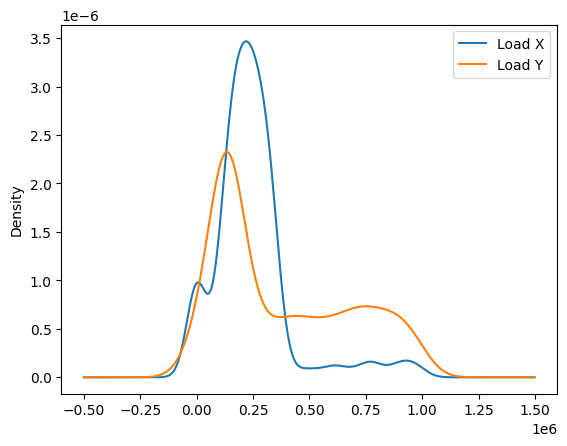

In [151]:
dataset_df_raw.plot(x="Temperature", y=["Load X", "Load Y"], kind='kde')
plt.show()

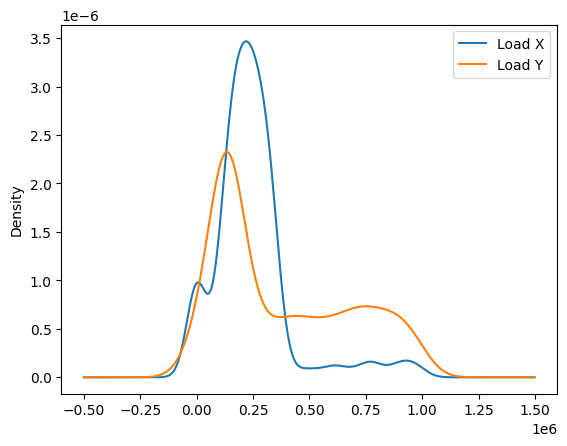

In [152]:
dataset_df_raw.plot(x="Depth Of Cut", y=["Load X", "Load Y"], kind='kde')
plt.show()

In [153]:
# Do a Yeo-Johnson transformation on the Temperature - to achieve a more Gaussian distribution.
dataset_transformed_df = dataset_df_raw.copy()
dataset_transformed_df['Temperature'], param = stats.yeojohnson(dataset_transformed_df['Temperature'])

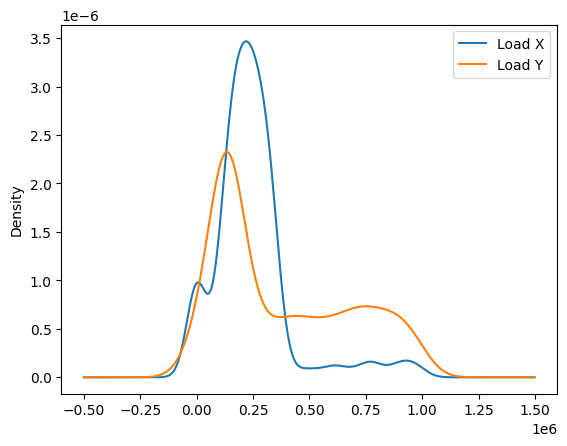

In [154]:
dataset_transformed_df.plot(x="Temperature", y=["Load X", "Load Y"], kind='kde')
plt.show()

In [155]:
def normalize_min_max(df, var_name):
    df[var_name]=(df[var_name]-df[var_name].min())/(df[var_name].max()-df[var_name].min())
    return df

In [156]:
# Normalize the variables that are not in the 0-1 range, except the Length of Cut as it is not too large.
dataset_transformed_df = normalize_min_max(dataset_transformed_df, 'Temperature')
dataset_transformed_df = normalize_min_max(dataset_transformed_df, 'Load X')
dataset_transformed_df = normalize_min_max(dataset_transformed_df, 'Load Y')

In [157]:
dataset_transformed_df.describe()

,Temperature,Depth Of Cut,Feed Rate,Lenght Of Cut,Load X,Load Y
count,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000
mean,0.563613,0.345603,0.181596,1.359112,0.245261,0.376889
std,0.140719,0.116225,0.051090,0.238655,0.179703,0.299942
min,0.000000,0.200000,0.100000,1.000000,0.000000,0.000000
25%,0.472054,0.200000,0.150000,1.000000,0.154768,0.126112
50%,0.544045,0.300000,0.200000,1.500000,0.223112,0.231283
75%,0.645028,0.450000,0.200000,1.500000,0.301194,0.651553
max,1.000000,0.500000,0.500000,1.600000,1.000000,1.000000


In [109]:
# Visualize the cleaned data.

In [113]:
dataset_transformed_df.head()

,Temperature,Depth Of Cut,Feed Rate,Lenght Of Cut,Load X,Load Y
1,0.051565,0.2,0.2,1.5,0.599117,0.671757
2,0.051786,0.2,0.2,1.5,0.768693,0.738724
3,0.051819,0.2,0.2,1.5,0.891045,0.138508
4,0.051829,0.2,0.2,1.5,0.962245,0.014605
5,0.051945,0.2,0.2,1.5,1.000000,0.141280


In [114]:
dataset_transformed_df.describe()

,Temperature,Depth Of Cut,Feed Rate,Lenght Of Cut,Load X,Load Y
count,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000
mean,0.100916,0.345603,0.181596,1.359112,0.245261,0.376889
std,0.112854,0.116225,0.051090,0.238655,0.179703,0.299942
min,0.000000,0.200000,0.100000,1.000000,0.000000,0.000000
25%,0.057827,0.200000,0.150000,1.000000,0.154768,0.126112
50%,0.074940,0.300000,0.200000,1.500000,0.223112,0.231283
75%,0.108007,0.450000,0.200000,1.500000,0.301194,0.651553
max,1.000000,0.500000,0.500000,1.600000,1.000000,1.000000


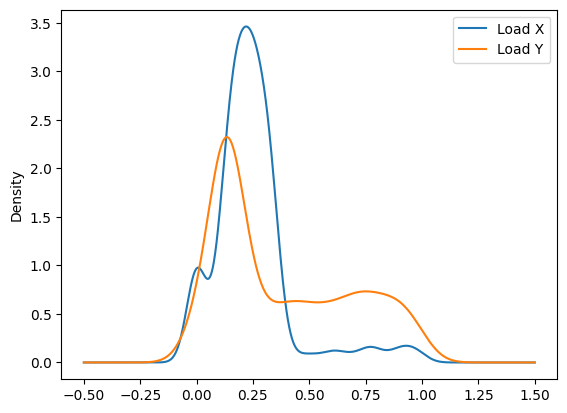

In [93]:
dataset_transformed_df.plot(x="Temperature", y=["Load X", "Load Y"], kind='kde')
plt.show()

In [159]:
# Split the cleaned and transformed data into training and testing sets with a 90/10 ratio.
train_df, test_df = train_test_split(dataset_transformed_df, test_size=0.1, random_state=42)

Training set:
     Temperature  Depth Of Cut  Feed Rate  Lenght Of Cut    Load X    Load Y
19      0.456590          0.50       0.20            1.0  0.165929  0.399006
159     0.756426          0.20       0.20            1.5  0.331806  0.157701
8       0.442253          0.45       0.15            1.6  0.929562  0.142028
11      0.446367          0.50       0.20            1.0  0.139205  0.030227
40      0.485941          0.30       0.20            1.0  0.119853  0.506725
..           ...           ...        ...            ...       ...       ...
43      0.490161          0.30       0.20            1.5  0.211508  0.588204
122     0.697502          0.20       0.20            1.5  0.000263  0.141543
32      0.464546          0.20       0.20            1.5  0.155411  0.510476
83      0.564494          0.20       0.20            1.5  0.310499  0.123647
14      0.453371          0.40       0.15            1.5  0.113959  0.220641

[992 rows x 6 columns]

Testing set:
     Temperature  Depth 

In [160]:
# Export the data sets.
train_df.to_csv('./data/dataset_train.csv', index=False)
test_df.to_csv('./data/dataset_test.csv', index=False)